In [1]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')
import math

# from scipy import stats
from scipy.stats import chi2, chi2_contingency
import statsmodels.stats.api as sms

import ttd_experiment as ttd

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/wishpy/dataworker.py:83: UserWarning: [Errno 2] No such file or directory: '../../../wishpy/client_secret.json'
  warnings.warn(str(e))


In [37]:
df_lrr = dw.td_query('''
select (case 
          when groups = 'ttd_estimate_service_control' then 'ttd_estimate_service_control_30popu'
          when groups = 'ttd_estimate_service_show' then 'ttd_estimate_service_show_20p_80p_20popu'
          when groups = 'ttd_estimate_service_show-v2' then 'ttd_estimate_service_show_v2_10p_80p_10popu'
          when groups = 'ttd_estimate_service_show-v3' then 'ttd_estimate_service_show_v3_10p_60p_10popu'
          when groups = 'ttd_estimate_service_show-v4' then 'ttd_estimate_service_show_v4_20p_50p_10popu'
          when groups = 'ttd_estimate_service_show-v5' then 'ttd_estimate_service_show_v5_50p_70p_10popu'
          else 'other'
        end) as new_groups
       ,count(user_id) as user_count
       
       ,round(avg(lrr),4) as lrr_userid_based
       ,round(STDDEV(lrr),4) as llr_stddev_userid_based
       ,round(avg(non_log_rr),4) as non_log_rr_userid_based
       ,round(STDDEV(non_log_rr),4) as non_log_rr_stddev_userid_based
       ,round(avg(overall_rr),4) as overall_rr_userid_based
       ,round(STDDEV(overall_rr),4) as overall_rr_stddev_userid_based
       
       ,sum(orders) as orders
       ,sum(l_refund_orders) as l_refund_orders
       ,sum(non_l_refund_orders) as non_l_refund_orders
       ,sum(overall_refund_orders) as overall_refund_orders
       ,round(100.0*sum(l_refund_orders)/sum(orders),4)/100.0 as lrr_txn_based
       ,round(100.0*sum(non_l_refund_orders)/sum(orders),4)/100.0 as non_l_rr_txn_based
       ,round(100.0*sum(overall_refund_orders)/sum(orders),4)/100.0 as overall_rr_txn_based
from (
select groups
       ,user_id
       ,count(m_transaction_id) as orders
       ,count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL)) as l_refund_orders
       ,count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL)) as non_l_refund_orders
       ,count(if(refund_reason_category is not NULL,m_transaction_id,NULL)) as overall_refund_orders
       
       ,round(count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as lrr
       ,round(count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as non_log_rr
       ,round(count(if(refund_reason_category is not NULL,m_transaction_id,NULL))/count(m_transaction_id),4) as overall_rr
from analytics.jay_ttd_exp_lrr_20190522_20190709
where groups != 'other'
      and bot_user = 0
group by groups
       ,user_id
) as temp
group by groups
'''
# ,job_id=726685914
,engine = 'presto'
                )

You can look at job id 726882639


In [17]:
df_lrr_dt = dw.td_query('''
select (case 
          when groups = 'ttd_estimate_service_control' then 'ttd_estimate_service_control_30popu'
          when groups = 'ttd_estimate_service_show' then 'ttd_estimate_service_show_20p_80p_20popu'
          when groups = 'ttd_estimate_service_show-v2' then 'ttd_estimate_service_show_v2_10p_80p_10popu'
          when groups = 'ttd_estimate_service_show-v3' then 'ttd_estimate_service_show_v3_10p_60p_10popu'
          when groups = 'ttd_estimate_service_show-v4' then 'ttd_estimate_service_show_v4_20p_50p_10popu'
          when groups = 'ttd_estimate_service_show-v5' then 'ttd_estimate_service_show_v5_50p_70p_10popu'
          else 'other'
        end) as new_groups
       ,order_dt
       
       ,count(user_id) as user_count
       
       ,round(avg(lrr),4) as lrr_userid_based
       ,round(STDDEV(lrr),4) as llr_stddev_userid_based
       ,round(avg(non_log_rr),4) as non_log_rr_userid_based
       ,round(STDDEV(non_log_rr),4) as non_log_rr_stddev_userid_based
       ,round(avg(overall_rr),4) as overall_rr_userid_based
       ,round(STDDEV(overall_rr),4) as overall_rr_stddev_userid_based
       
       ,sum(orders) as orders
       ,sum(l_refund_orders) as l_refund_orders
       ,sum(non_l_refund_orders) as non_l_refund_orders
       ,sum(overall_refund_orders) as overall_refund_orders
       ,round(100.0*sum(l_refund_orders)/sum(orders),4)/100.0 as lrr_txn_based
       ,round(100.0*sum(non_l_refund_orders)/sum(orders),4)/100.0 as non_l_rr_txn_based
       ,round(100.0*sum(overall_refund_orders)/sum(orders),4)/100.0 as overall_rr_txn_based
from (
select groups
       ,order_dt
       ,user_id
       ,count(m_transaction_id) as orders
       ,count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL)) as l_refund_orders
       ,count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL)) as non_l_refund_orders
       ,count(if(refund_reason_category is not NULL,m_transaction_id,NULL)) as overall_refund_orders
       
       ,round(count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as lrr
       ,round(count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as non_log_rr
       ,round(count(if(refund_reason_category is not NULL,m_transaction_id,NULL))/count(m_transaction_id),4) as overall_rr
from analytics.jay_ttd_exp_lrr_20190522_20190709
where groups != 'other'
      and bot_user = 0
group by groups
       ,order_dt
       ,user_id
) as temp
group by groups
       ,order_dt
'''
 ,job_id=726882831
,engine = 'presto'
                )

You can look at job id 726882831


In [38]:
df_lrr_dt_country = dw.td_query('''
select (case 
          when groups = 'ttd_estimate_service_control' then 'ttd_estimate_service_control_30popu'
          when groups = 'ttd_estimate_service_show' then 'ttd_estimate_service_show_20p_80p_20popu'
          when groups = 'ttd_estimate_service_show-v2' then 'ttd_estimate_service_show_v2_10p_80p_10popu'
          when groups = 'ttd_estimate_service_show-v3' then 'ttd_estimate_service_show_v3_10p_60p_10popu'
          when groups = 'ttd_estimate_service_show-v4' then 'ttd_estimate_service_show_v4_20p_50p_10popu'
          when groups = 'ttd_estimate_service_show-v5' then 'ttd_estimate_service_show_v5_50p_70p_10popu'
          else 'other'
        end) as new_groups
       ,order_dt
       ,shipping_country
       ,count(user_id) as user_count
       
       ,round(avg(lrr),4) as lrr_userid_based
       ,round(STDDEV(lrr),4) as llr_stddev_userid_based
       ,round(avg(non_log_rr),4) as non_log_rr_userid_based
       ,round(STDDEV(non_log_rr),4) as non_log_rr_stddev_userid_based
       ,round(avg(overall_rr),4) as overall_rr_userid_based
       ,round(STDDEV(overall_rr),4) as overall_rr_stddev_userid_based
       
       ,sum(orders) as orders
       ,sum(l_refund_orders) as l_refund_orders
       ,sum(non_l_refund_orders) as non_l_refund_orders
       ,sum(overall_refund_orders) as overall_refund_orders
       ,round(100.0*sum(l_refund_orders)/sum(orders),4)/100.0 as lrr_txn_based
       ,round(100.0*sum(non_l_refund_orders)/sum(orders),4)/100.0 as non_l_rr_txn_based
       ,round(100.0*sum(overall_refund_orders)/sum(orders),4)/100.0 as overall_rr_txn_based
from (
select groups
       ,order_dt
       ,shipping_country
       ,user_id
       ,count(m_transaction_id) as orders
       ,count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL)) as l_refund_orders
       ,count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL)) as non_l_refund_orders
       ,count(if(refund_reason_category is not NULL,m_transaction_id,NULL)) as overall_refund_orders
       
       ,round(count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as lrr
       ,round(count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as non_log_rr
       ,round(count(if(refund_reason_category is not NULL,m_transaction_id,NULL))/count(m_transaction_id),4) as overall_rr
from analytics.jay_ttd_exp_lrr_20190522_20190709
where groups != 'other'
      and bot_user = 0
group by groups
       ,order_dt
       ,shipping_country
       ,user_id
) as temp
group by groups
       ,order_dt
       ,shipping_country
'''
# ,job_id=725816212
,engine = 'presto'
                )

You can look at job id 726882738


In [2]:
df_lrr_all_cut = dw.td_query('''
select (case 
          when groups = 'ttd_estimate_service_control' then 'ttd_estimate_service_control_30popu'
          when groups = 'ttd_estimate_service_show' then 'ttd_estimate_service_show_20p_80p_20popu'
          when groups = 'ttd_estimate_service_show-v2' then 'ttd_estimate_service_show_v2_10p_80p_10popu'
          when groups = 'ttd_estimate_service_show-v3' then 'ttd_estimate_service_show_v3_10p_60p_10popu'
          when groups = 'ttd_estimate_service_show-v4' then 'ttd_estimate_service_show_v4_20p_50p_10popu'
          when groups = 'ttd_estimate_service_show-v5' then 'ttd_estimate_service_show_v5_50p_70p_10popu'
          else 'other'
        end) as new_groups
       ,order_dt
       ,shipping_country
       ,gender
       ,education_level
       ,is_new_user
       ,is_free_item
       ,is_ltd_product
       ,wishpost_registered
       
       ,round(avg(lrr),4) as lrr_userid_based
       ,round(STDDEV(lrr),4) as llr_stddev_userid_based
       ,round(avg(non_log_rr),4) as non_log_rr_userid_based
       ,round(STDDEV(non_log_rr),4) as non_log_rr_stddev_userid_based
       ,round(avg(overall_rr),4) as overall_rr_userid_based
       ,round(STDDEV(overall_rr),4) as overall_rr_stddev_userid_based
       
       ,sum(orders) as orders
       ,sum(l_refund_orders) as l_refund_orders
       ,sum(non_l_refund_orders) as non_l_refund_orders
       ,sum(overall_refund_orders) as overall_refund_orders
       ,round(100.0*sum(l_refund_orders)/sum(orders),4)/100.0 as lrr_txn_based
       ,round(100.0*sum(non_l_refund_orders)/sum(orders),4)/100.0 as non_l_rr_txn_based
       ,round(100.0*sum(overall_refund_orders)/sum(orders),4)/100.0 as overall_rr_txn_based
from (
select groups
       ,order_dt
       ,shipping_country
       ,gender
       ,education_level
       ,is_new_user
       ,if(is_free_gift='true' or is_free_sample='true',1,0) as is_free_item
       ,is_ltd_product
       ,coalesce(wishpost_registered,'false') as wishpost_registered
       ,user_id
       
       ,count(m_transaction_id) as orders
       ,count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL)) as l_refund_orders
       ,count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL)) as non_l_refund_orders
       ,count(if(refund_reason_category is not NULL,m_transaction_id,NULL)) as overall_refund_orders
       
       ,round(count(if(refund_reason_category in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as lrr
       ,round(count(if(refund_reason_category not in (20,35,38),m_transaction_id,NULL))/count(m_transaction_id),4) as non_log_rr
       ,round(count(if(refund_reason_category is not NULL,m_transaction_id,NULL))/count(m_transaction_id),4) as overall_rr
from analytics.jay_ttd_exp_lrr_20190522_20190709
where groups != 'other'
      and bot_user = 0
group by 1,2,3,4,5,6,7,8,9,10
) as temp
group by 1,2,3,4,5,6,7,8,9
'''
 ,job_id=727203459
,engine = 'presto'
                )

You can look at job id 727203459


In [19]:
df_lrr_dt.head()

new_groups    order_dt  user_count  \
0          ttd_estimate_service_control_30popu  2019-06-15      152809   
1     ttd_estimate_service_show_20p_80p_20popu  2019-07-06      114972   
2     ttd_estimate_service_show_20p_80p_20popu  2019-06-03      115232   
3  ttd_estimate_service_show_v2_10p_80p_10popu  2019-06-24      110140   
4     ttd_estimate_service_show_20p_80p_20popu  2019-07-03      117155   

   lrr_userid_based  llr_stddev_userid_based  non_log_rr_userid_based  \
0            0.0376                   0.1903                   0.0500   
1            0.0425                   0.2018                   0.0526   
2            0.0392                   0.1940                   0.0565   
3            0.0430                   0.2028                   0.0582   
4            0.0437                   0.2044                   0.0533   

   non_log_rr_stddev_userid_based  overall_rr_userid_based  \
0                          0.2179                   0.0899   
1                          0.2232                   0.0988   
2                          0.2309                   0.0989   
3                          0.2341                   0.1047   
4                          0.2246                   0.1008   

   overall_rr_stddev_userid_based  orders  l_refund_orders  \
0                          0.2860  434625            21538   
1                          0.2984  329302            18008   
2                          0.2985  336921            18322   
3                          0.3062  298980            16544   
4                          0.3010  329377            18291   

   non_l_refund_orders  overall_refund_orders  lrr_txn_based  \
0                31098                  52636       0.049555   
1                24868                  42876       0.054685   
2                28366                  46688       0.054381   
3                23829                  40373       0.055335   
4                26088                  44379       0.055532   

   non_l_rr_txn_based  overall_rr_txn_based  
0            0.071551              0.121107  
1            0.075517              0.130203  
2            0.084192              0.138573  
3            0.079701              0.135036  
4            0.079204              0.134736

## LRR overall over date plot

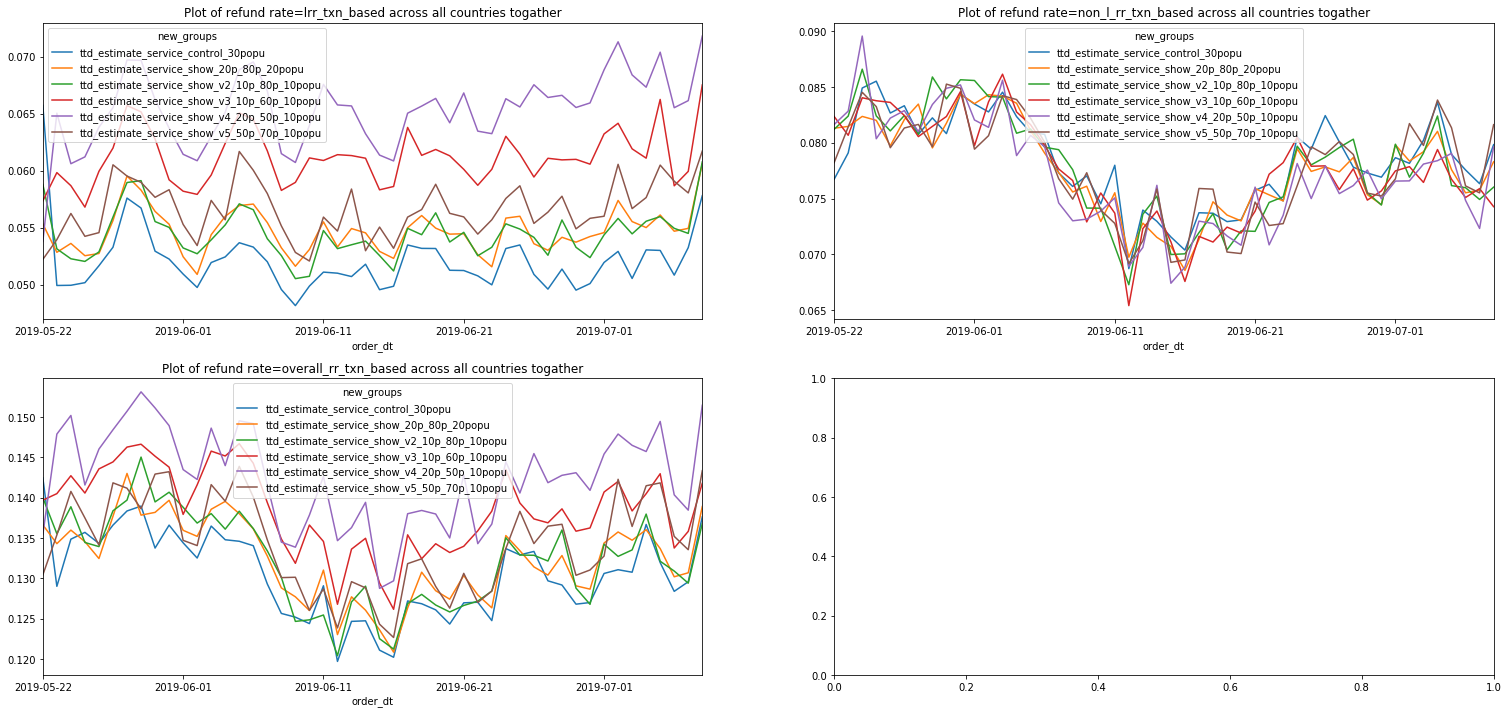

In [20]:
metrics = ['lrr_txn_based','non_l_rr_txn_based','overall_rr_txn_based']
m = 2
n = (len(metrics)+1) // m
fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))

for i in range(len(metrics)):
    x = i//m
    y = i%m
    
    df_lrr_dt[['order_dt','new_groups',metrics[i]]].pivot_table(columns='new_groups', values=metrics[i], index='order_dt')\
    .plot(ax=axes[x][y], title='Plot of refund rate={} across all countries togather'.format(metrics[i]))

In [21]:
df_lrr_dt.head()

new_groups    order_dt  user_count  \
0          ttd_estimate_service_control_30popu  2019-06-15      152809   
1     ttd_estimate_service_show_20p_80p_20popu  2019-07-06      114972   
2     ttd_estimate_service_show_20p_80p_20popu  2019-06-03      115232   
3  ttd_estimate_service_show_v2_10p_80p_10popu  2019-06-24      110140   
4     ttd_estimate_service_show_20p_80p_20popu  2019-07-03      117155   

   lrr_userid_based  llr_stddev_userid_based  non_log_rr_userid_based  \
0            0.0376                   0.1903                   0.0500   
1            0.0425                   0.2018                   0.0526   
2            0.0392                   0.1940                   0.0565   
3            0.0430                   0.2028                   0.0582   
4            0.0437                   0.2044                   0.0533   

   non_log_rr_stddev_userid_based  overall_rr_userid_based  \
0                          0.2179                   0.0899   
1                          0.2232                   0.0988   
2                          0.2309                   0.0989   
3                          0.2341                   0.1047   
4                          0.2246                   0.1008   

   overall_rr_stddev_userid_based  orders  l_refund_orders  \
0                          0.2860  434625            21538   
1                          0.2984  329302            18008   
2                          0.2985  336921            18322   
3                          0.3062  298980            16544   
4                          0.3010  329377            18291   

   non_l_refund_orders  overall_refund_orders  lrr_txn_based  \
0                31098                  52636       0.049555   
1                24868                  42876       0.054685   
2                28366                  46688       0.054381   
3                23829                  40373       0.055335   
4                26088                  44379       0.055532   

   non_l_rr_txn_based  overall_rr_txn_based  
0            0.071551              0.121107  
1            0.075517              0.130203  
2            0.084192              0.138573  
3            0.079701              0.135036  
4            0.079204              0.134736

In [31]:
# show_groups = ['ttd_estimate_service_show_20p_80p_20popu','ttd_estimate_service_show_v2_10p_80p_10popu','ttd_estimate_service_show_v3_10p_60p_10popu',\
#                'ttd_estimate_service_show_v4_20p_50p_10popu','ttd_estimate_service_show_v5_50p_70p_10popu']
show_groups = ['ttd_estimate_service_show_20p_80p_20popu']
for group in show_groups:
    p,mean_a,mean_b = ttd.t_test_classic(df=df_lrr_dt,treatment_name='ttd_estimate_service_show_20p_80p_20popu',control_name='ttd_estimate_service_show_v2_10p_80p_10popu',imp='orders',clk='l_refund_orders')
    print('the mean for "ttd_estimate_service_show_v2_10p_80p_10popu" group is {}, the mean for treatment group "{}" is {}'.format(mean_a,group,mean_b))
    print('the p-value of classic T test of treatment group - "{}", is {}'.format(group,p))
    if p <= 0.05: 
        print('which means there is a significant difference between control and "{}" groups'.format(group))
    else:
        print('which means there is no significant evidence to support differece between control and {} groups'.format(group))
    print(100*'_')
    print('\n')
    
for group in show_groups:
    p,mean_a,mean_b = ttd.t_test_welchs(df=df_lrr_dt,treatment_name='ttd_estimate_service_show_20p_80p_20popu',control_name='ttd_estimate_service_show_v2_10p_80p_10popu',imp='orders',clk='l_refund_orders')
    print('the mean for "ttd_estimate_service_show_v2_10p_80p_10popu" group is {}, the mean for treatment group "{}" is {}'.format(mean_a,group,mean_b))
    print('the p-value of Welchs T test of treatment group - "{}", is {}'.format(group,p))
    if p <= 0.05: 
        print('which means there is a significant difference between control and "{}" groups'.format(group))
    else:
        print('which means there is no significant evidence to support differece between control and {} groups'.format(group))
    print(100*'_')
    print('\n')

the mean for "ttd_estimate_service_show_v2_10p_80p_10popu" group is 0.05443073430086941, the mean for treatment group "ttd_estimate_service_show_20p_80p_20popu" is 0.05466457630411319
the p-value of classic T test of treatment group - "ttd_estimate_service_show_20p_80p_20popu", is 0.004330250579183792
which means there is a significant difference between control and "ttd_estimate_service_show_20p_80p_20popu" groups
____________________________________________________________________________________________________


the mean for "ttd_estimate_service_show_v2_10p_80p_10popu" group is 0.05443073430086941, the mean for treatment group "ttd_estimate_service_show_20p_80p_20popu" is 0.05466457630411319
the p-value of Welchs T test of treatment group - "ttd_estimate_service_show_20p_80p_20popu", is 0.004330349560640379
which means there is a significant difference between control and "ttd_estimate_service_show_20p_80p_20popu" groups
____________________________________________________________

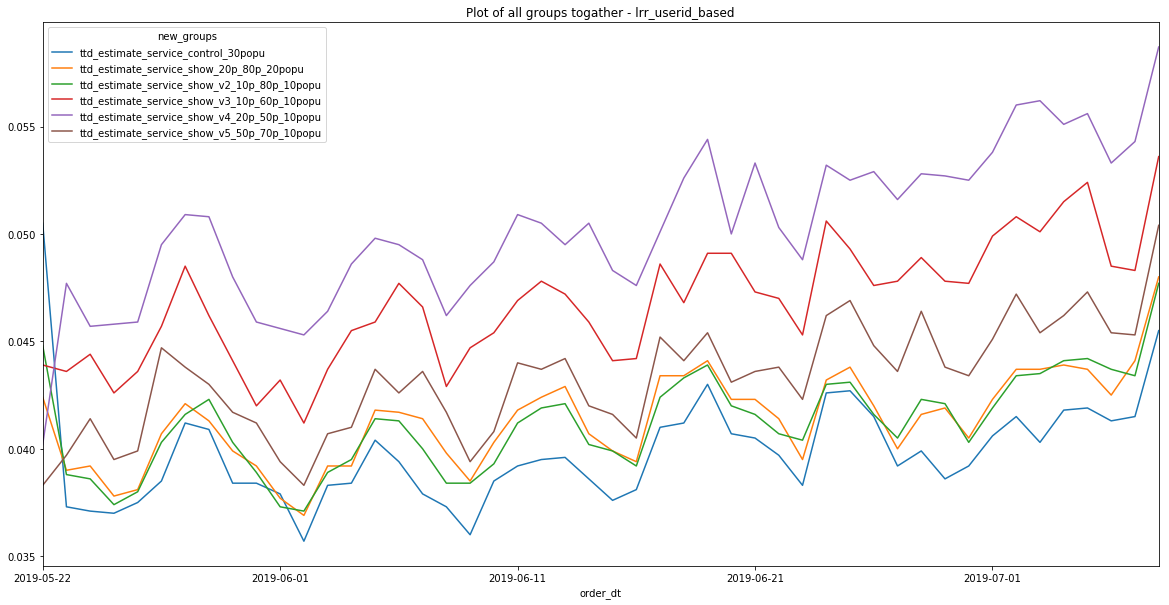

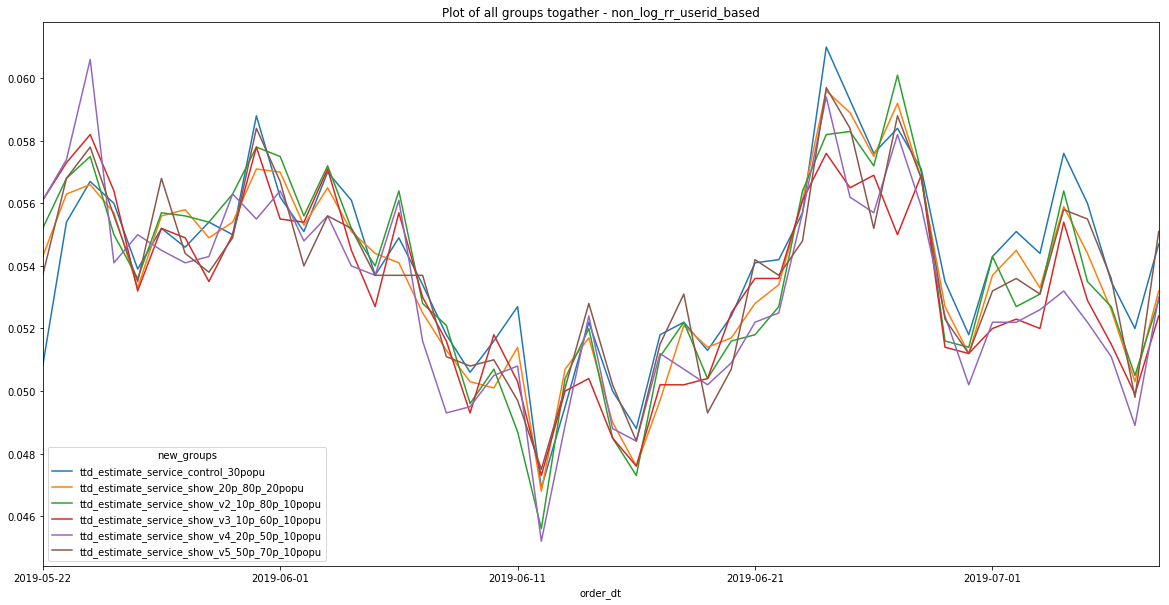

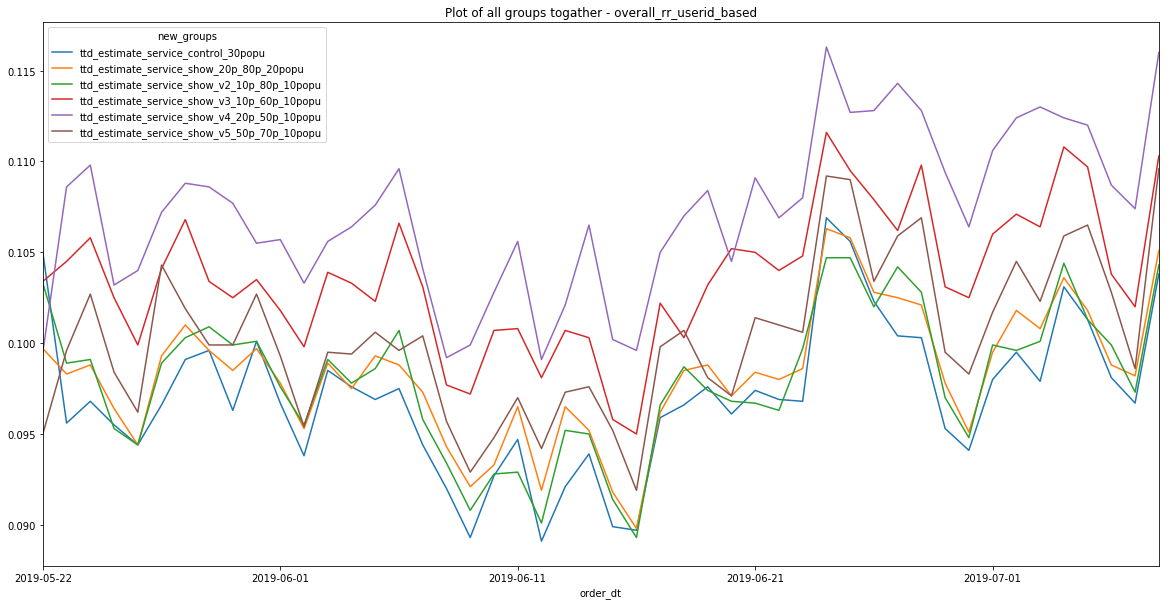

In [41]:
metrics = ['lrr_userid_based','non_log_rr_userid_based','overall_rr_userid_based']
for metric in metrics:
    df_lrr_dt[['order_dt','new_groups',metric]].pivot_table(columns='new_groups', values=metric, index='order_dt').plot(figsize=(20, 10))
    plt.title('Plot of all groups togather - {}'.format(metric))

## top countries

In [42]:
df_lrr_dt_country.head()

new_groups    order_dt shipping_country  \
0  ttd_estimate_service_show_v5_50p_70p_10popu  2019-06-21               US   
1  ttd_estimate_service_show_v4_20p_50p_10popu  2019-05-25               CA   
2     ttd_estimate_service_show_20p_80p_20popu  2019-06-02               US   
3  ttd_estimate_service_show_v4_20p_50p_10popu  2019-05-28               US   
4  ttd_estimate_service_show_v2_10p_80p_10popu  2019-06-30               UA   

   user_count  lrr_userid_based  llr_stddev_userid_based  \
0       17121            0.0167                   0.1282   
1        2658            0.1084                   0.3109   
2       39650            0.0138                   0.1167   
3       17284            0.0188                   0.1358   
4         171            0.0409                   0.1987   

   non_log_rr_userid_based  non_log_rr_stddev_userid_based  \
0                   0.0371                          0.1891   
1                   0.0523                          0.2227   
2                   0.0434                          0.2037   
3                   0.0419                          0.2005   
4                   0.0760                          0.2658   

   overall_rr_userid_based  overall_rr_stddev_userid_based  orders  \
0                   0.0550                          0.2280   50494   
1                   0.1708                          0.3764    7643   
2                   0.0585                          0.2348  125260   
3                   0.0623                          0.2417   49795   
4                   0.1228                          0.3292     410   

   l_refund_orders  non_l_refund_orders  overall_refund_orders  lrr_txn_based  \
0             1110                 2708                   3818       0.021983   
1             1246                  635                   1881       0.163025   
2             2580                 9064                  11644       0.020597   
3             1201                 3278                   4479       0.024119   
4               34                   87                    121       0.082927   

   non_l_rr_txn_based  overall_rr_txn_based  
0            0.053630              0.075613  
1            0.083083              0.246108  
2            0.072361              0.092959  
3            0.065830              0.089949  
4            0.212195              0.295122

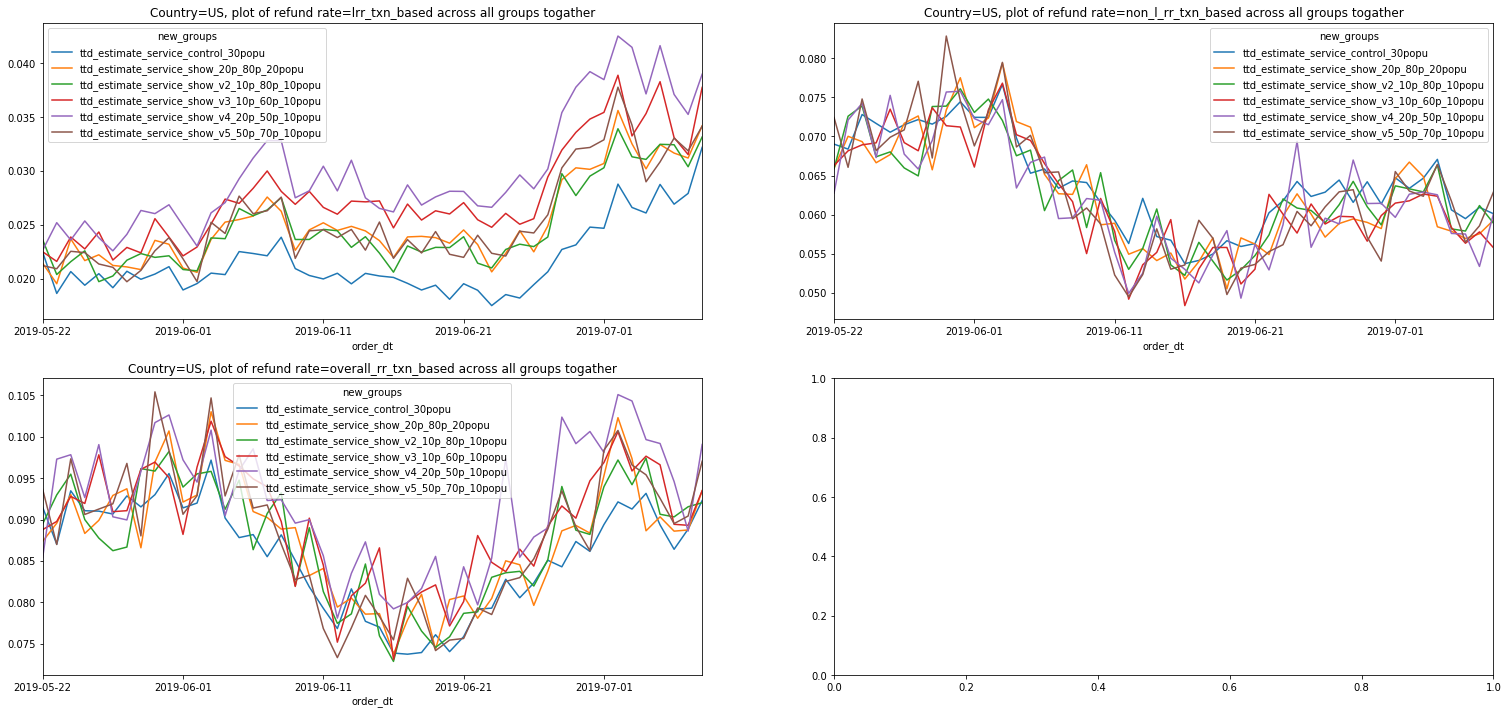

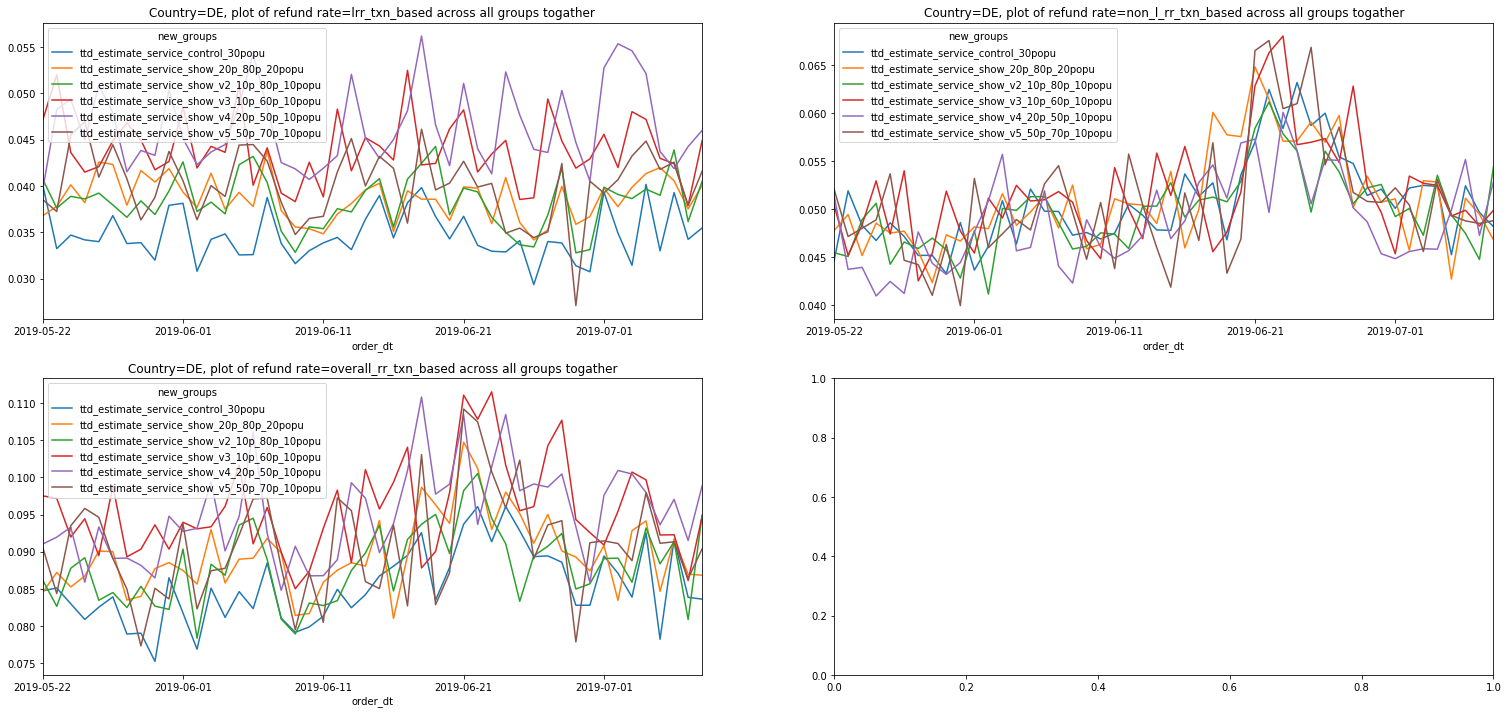

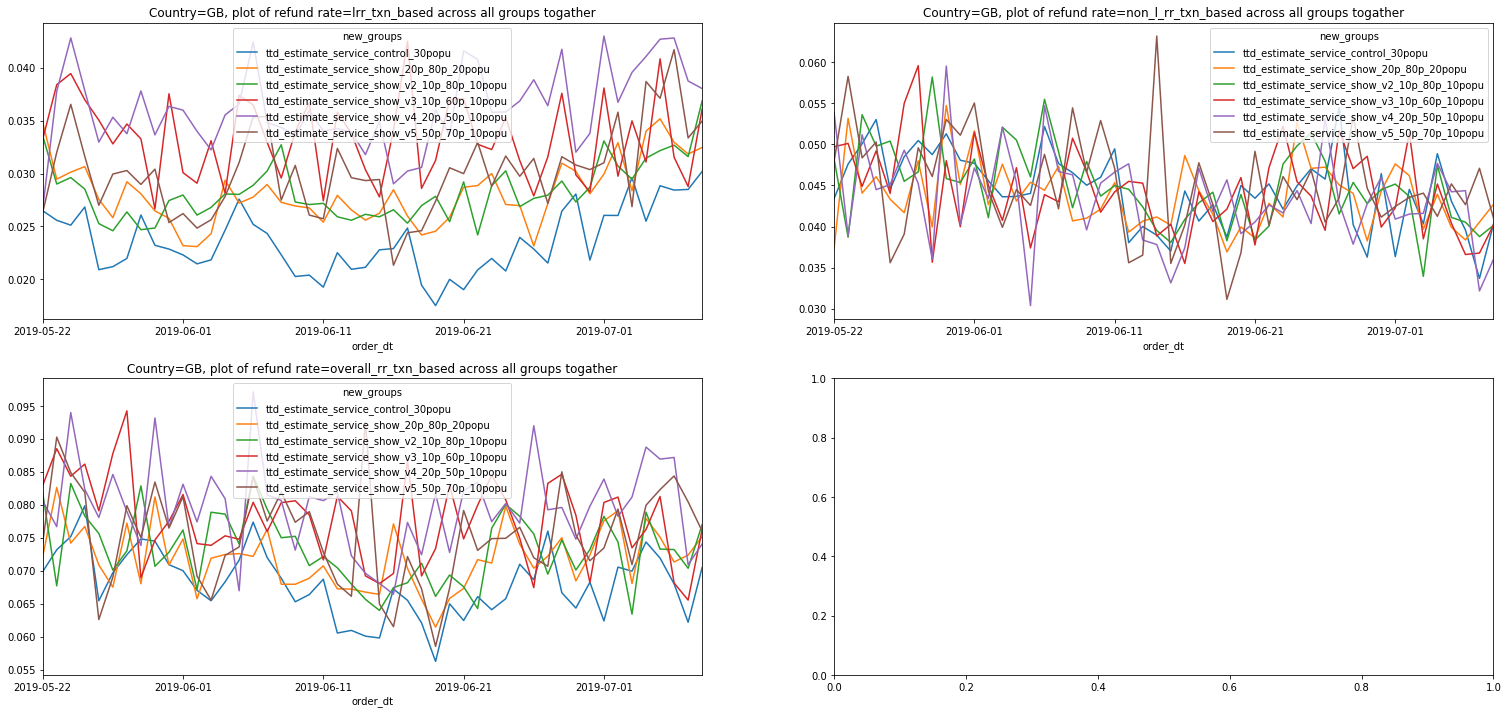

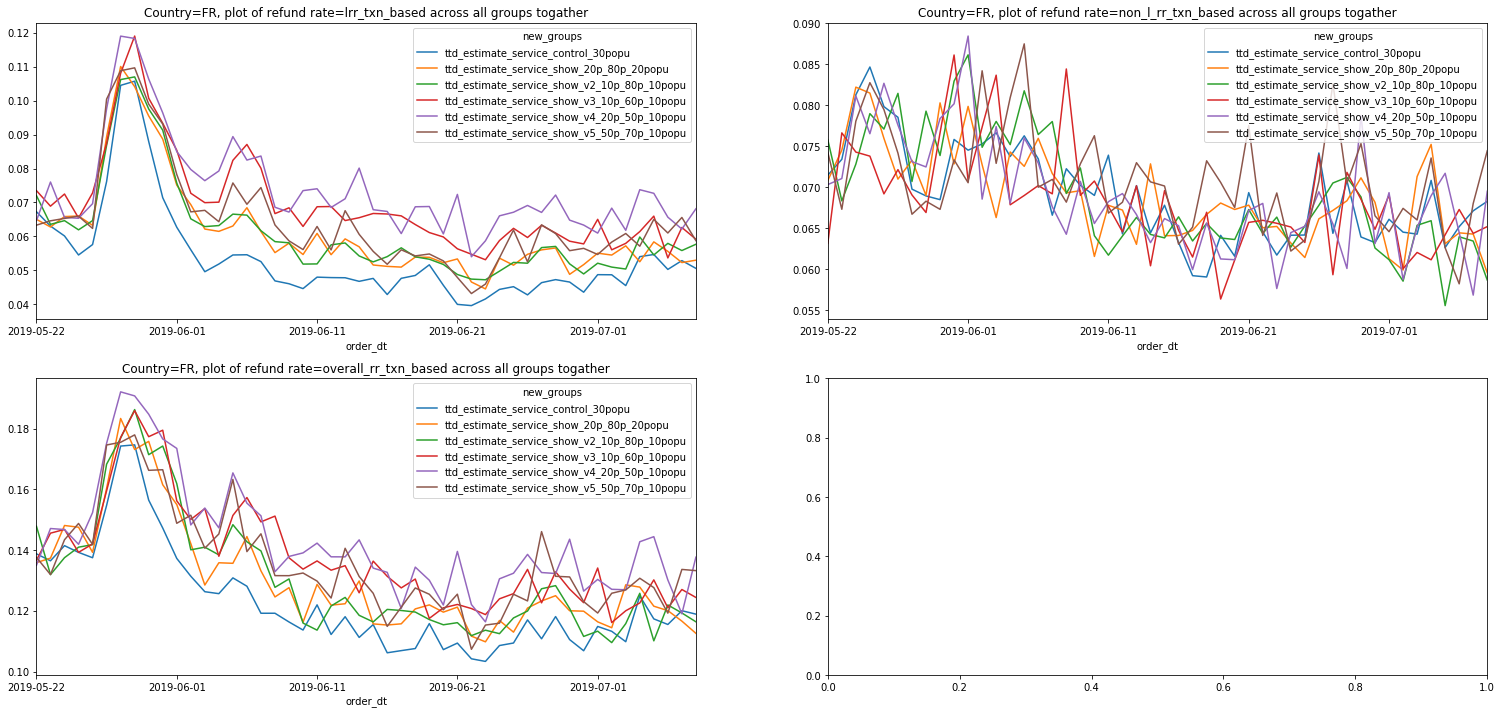

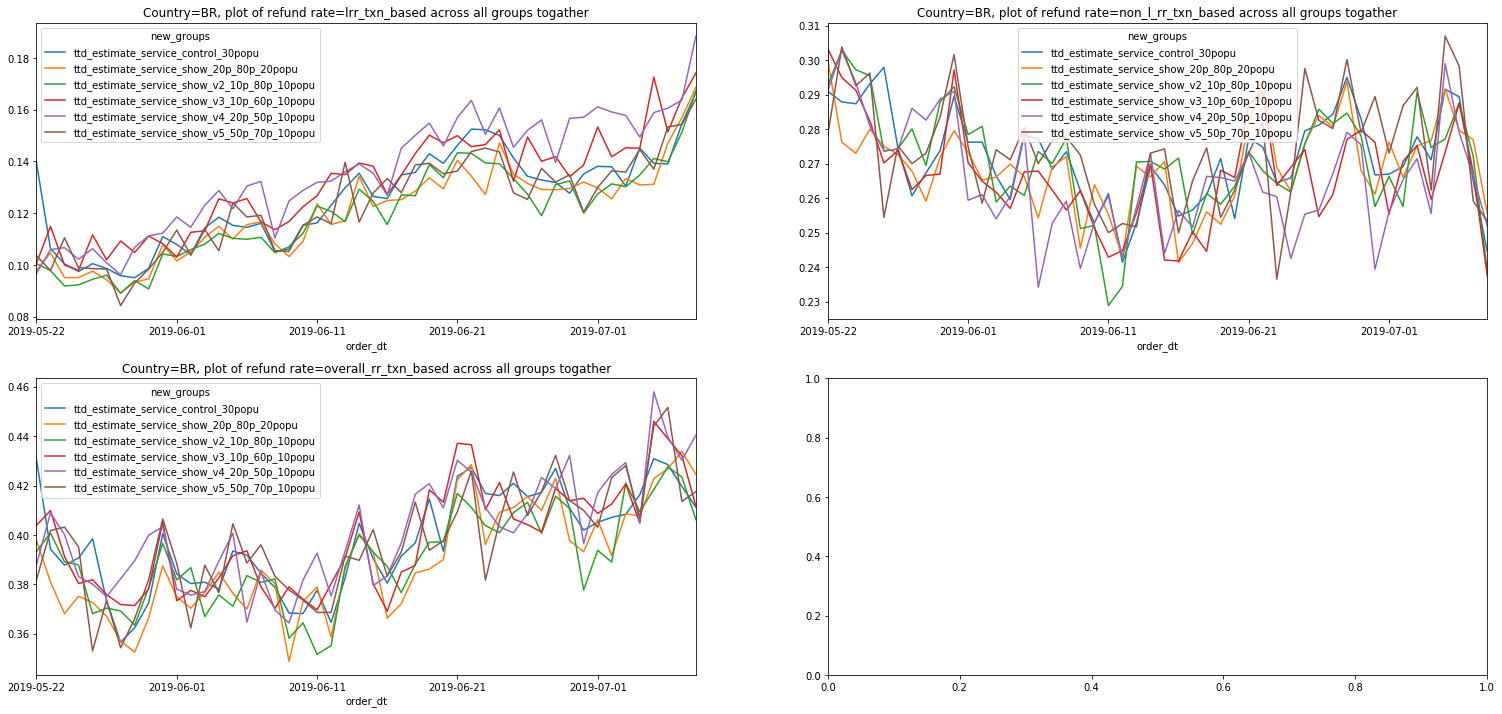

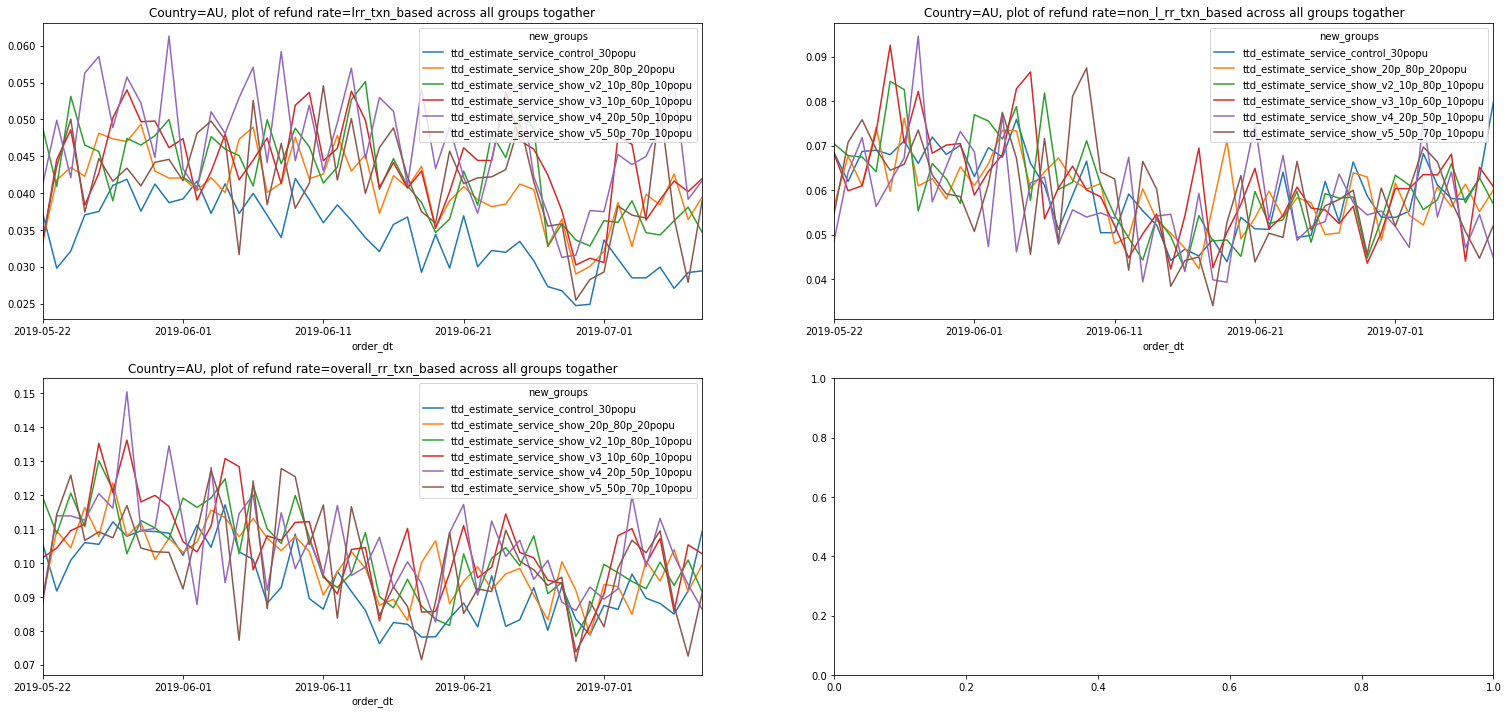

In [43]:
# df_lrr_dt_country_group =  df_lrr_dt_country.groupby(['new_groups','shipping_country','order_dt'],as_index=False)['orders','l_refund_orders','non_l_refund_orders','overall_refund_orders'].sum()
metrics = ['lrr_txn_based','non_l_rr_txn_based','overall_rr_txn_based']
countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU']

for c in countries:
    m = 2
    n = (len(metrics)+1) // m
    fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))
    for i in range(len(metrics)):
        x = i//m
        y = i%m
        df_lrr_dt_country.loc[df_lrr_dt_country.shipping_country==c,['order_dt','new_groups',metrics[i]]].pivot_table(columns='new_groups', values=metrics[i], index='order_dt')\
        .plot(ax=axes[x][y], title='Country={}, plot of refund rate={} across all groups togather'.format(c,metrics[i]))

In [47]:
df_lrr_all_cut.head()

new_groups    order_dt shipping_country  \
0     ttd_estimate_service_show_20p_80p_20popu  2019-07-05               FR   
1          ttd_estimate_service_control_30popu  2019-06-14               IT   
2  ttd_estimate_service_show_v3_10p_60p_10popu  2019-06-19               IE   
3     ttd_estimate_service_show_20p_80p_20popu  2019-05-23               DK   
4          ttd_estimate_service_control_30popu  2019-06-10               BE   

   gender  education_level  is_new_user  is_free_item is_ltd_product  \
0       1              NaN            0             0           None   
1       2              NaN            0             0           None   
2       2              NaN            0             0           None   
3       1              NaN            0             0           None   
4       1              NaN            0             0           None   

  wishpost_registered  lrr_userid_based  ...  non_log_rr_stddev_userid_based  \
0                true            0.0047  ...                          0.1848   
1               false            0.0037  ...                          0.1954   
2               false            0.0000  ...                          0.1387   
3                true            0.0076  ...                          0.1231   
4               false            0.0038  ...                          0.1489   

   overall_rr_userid_based  overall_rr_stddev_userid_based  orders  \
0                   0.0401                          0.1963    3231   
1                   0.0434                          0.2038    2546   
2                   0.0195                          0.1387     425   
3                   0.0229                          0.1502     191   
4                   0.0264                          0.1605    1476   

   l_refund_orders  non_l_refund_orders  overall_refund_orders  lrr_txn_based  \
0               25                  129                    154       0.007738   
1               30                  180                    210       0.011783   
2                6                    5                     11       0.014118   
3                2                    3                      5       0.010471   
4               23                   29                     52       0.015583   

   non_l_rr_txn_based  overall_rr_txn_based  
0            0.039926              0.047663  
1            0.070699              0.082482  
2            0.011765              0.025882  
3            0.015707              0.026178  
4            0.019648              0.035230  

[5 rows x 22 columns]

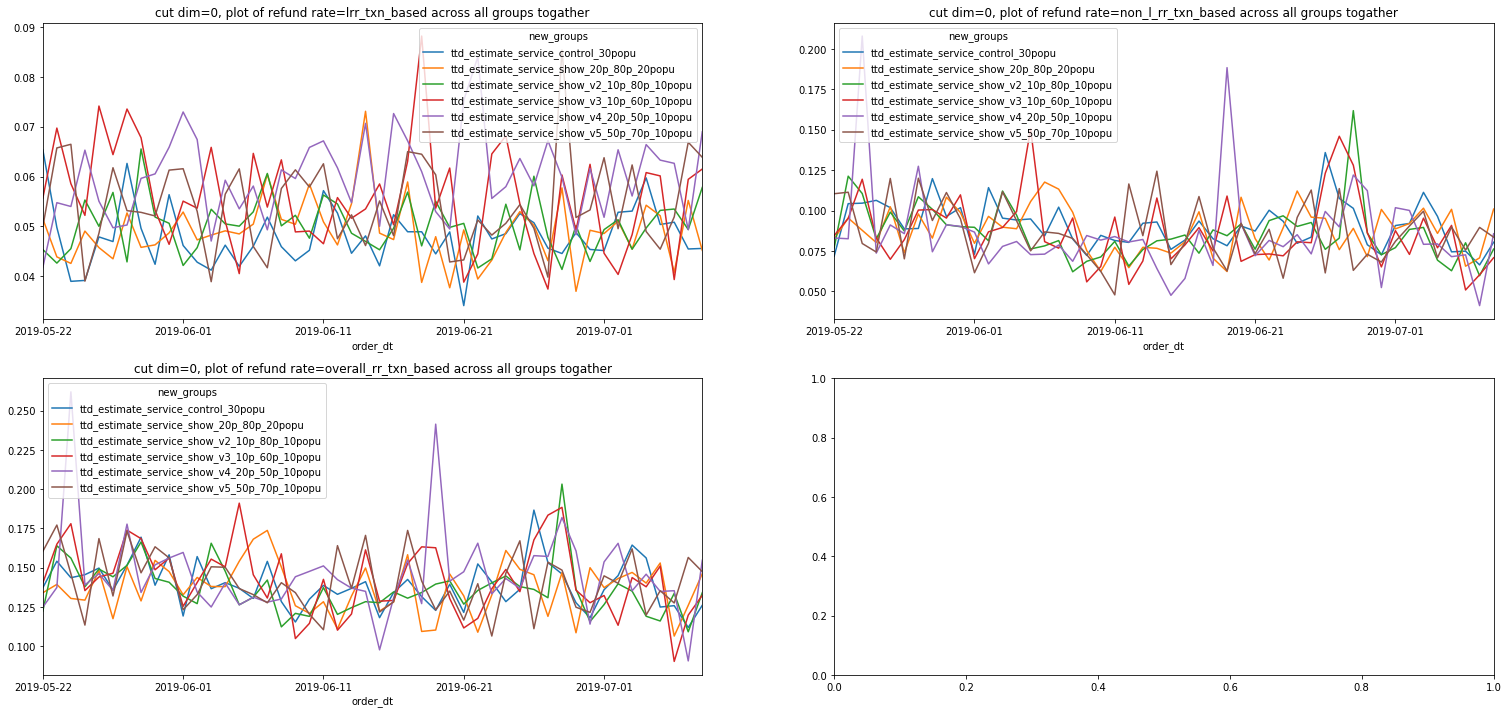

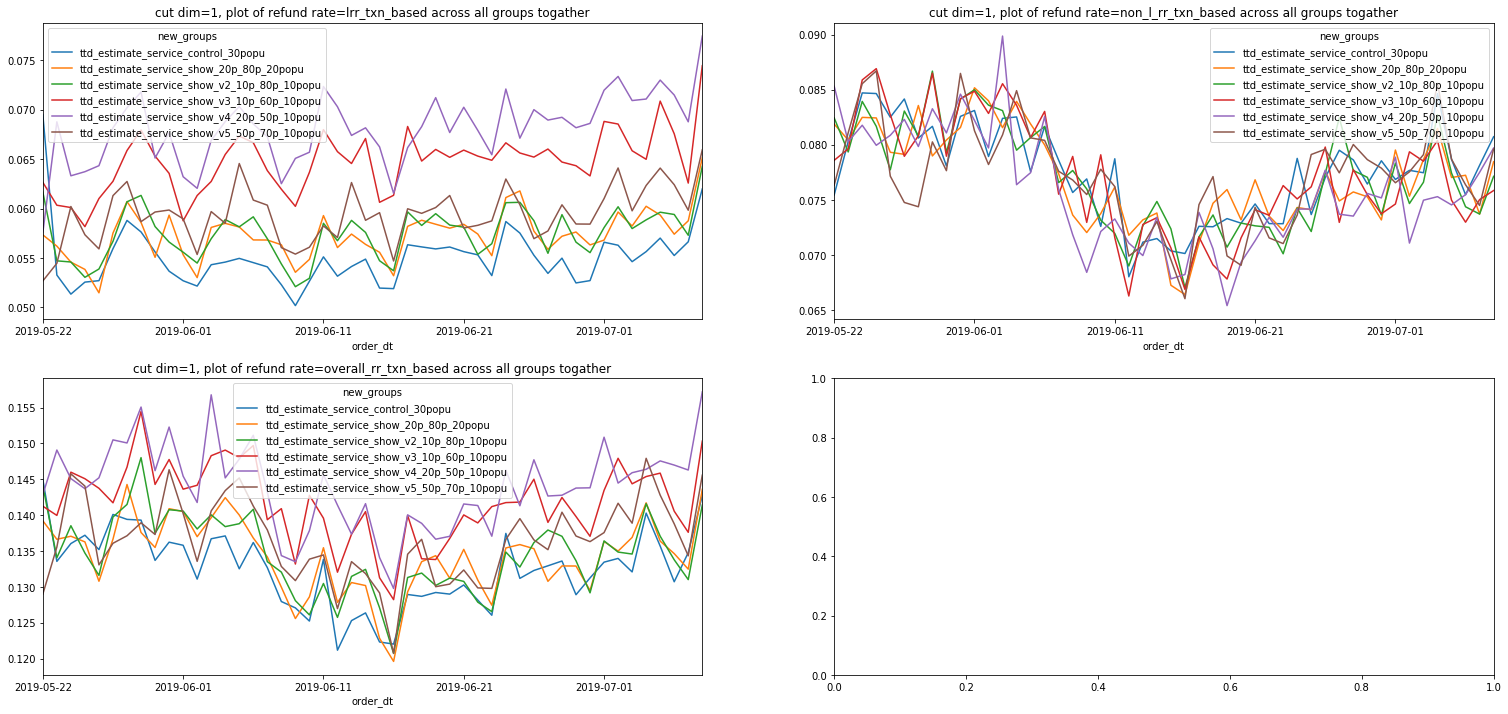

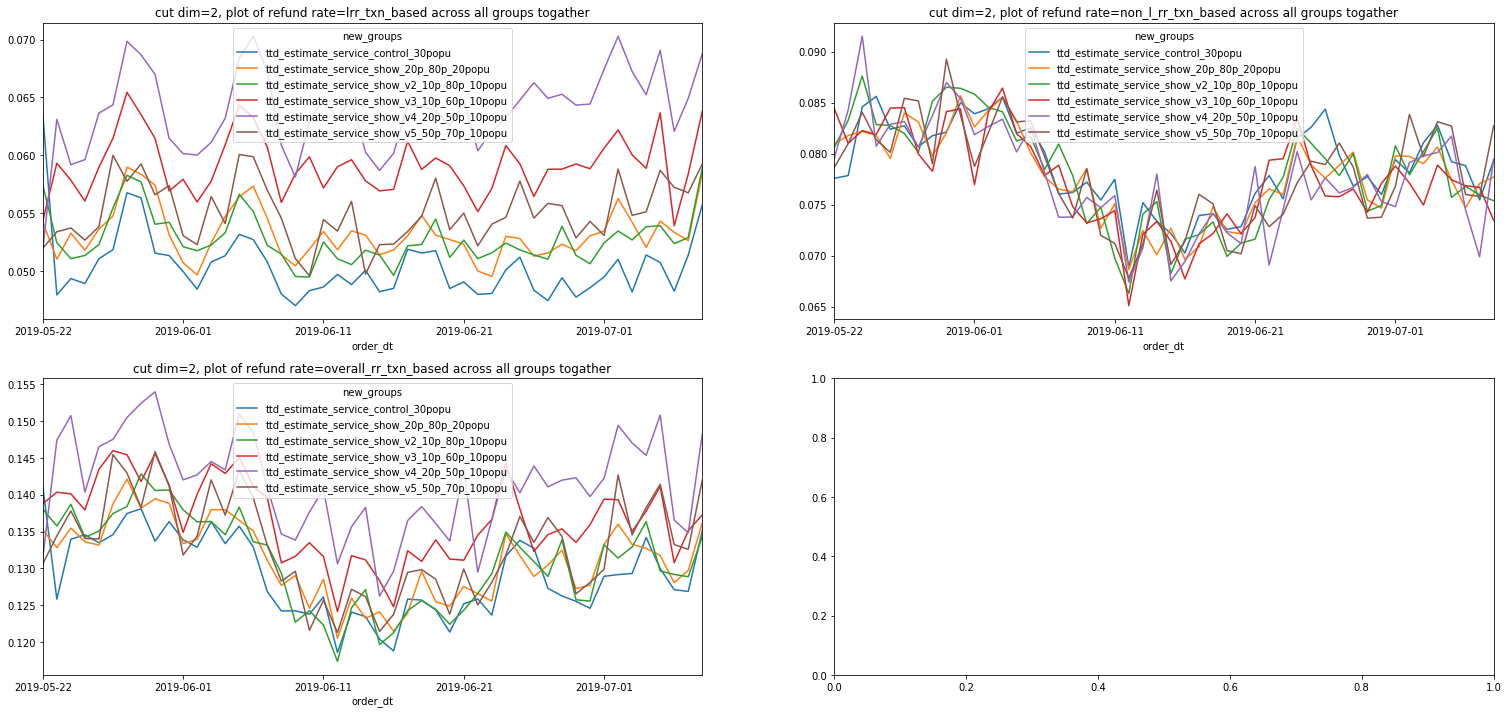

In [7]:
#df_cr_group =  df_cr.groupby('new_groups',as_index=False)['impression_contest_imp_based','click_commerce_add_to_cart_imp_based','click_buy_button_imp_based'].sum()
#group by operation
group = 'gender'
df_lrr_all_cut_group = df_lrr_all_cut.groupby(['new_groups','order_dt',group],as_index=False)['orders','l_refund_orders','non_l_refund_orders','overall_refund_orders'].sum()
df_lrr_all_cut_group['lrr_txn_based']=df_lrr_all_cut_group.l_refund_orders / df_lrr_all_cut_group.orders
df_lrr_all_cut_group['non_l_rr_txn_based']=df_lrr_all_cut_group.non_l_refund_orders / df_lrr_all_cut_group.orders
df_lrr_all_cut_group['overall_rr_txn_based']=df_lrr_all_cut_group.overall_refund_orders / df_lrr_all_cut_group.orders


groups = list(set(df_lrr_all_cut[group]))

metrics = ['lrr_txn_based','non_l_rr_txn_based','overall_rr_txn_based']
countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU']

for g in groups:
    m = 2
    n = (len(metrics)+1) // m
    fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))
    
    for i in range(len(metrics)):
        x = i//m
        y = i%m
        df_lrr_all_cut_group.loc[df_lrr_all_cut_group[group]==g,['order_dt','new_groups',metrics[i]]].pivot_table(columns='new_groups', values=metrics[i], index='order_dt')\
        .plot(ax=axes[x][y], title='cut dim={}, plot of refund rate={} across all groups togather'.format(g,metrics[i]))

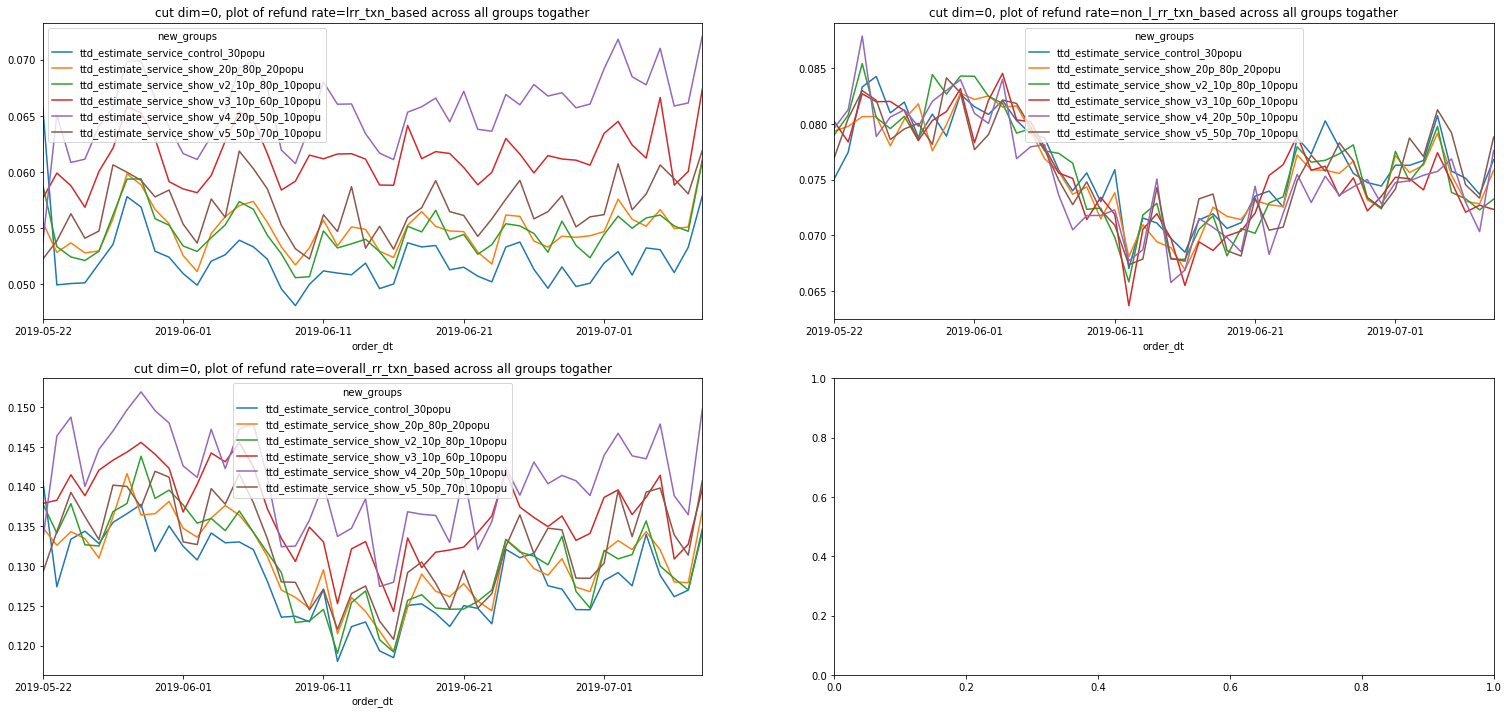

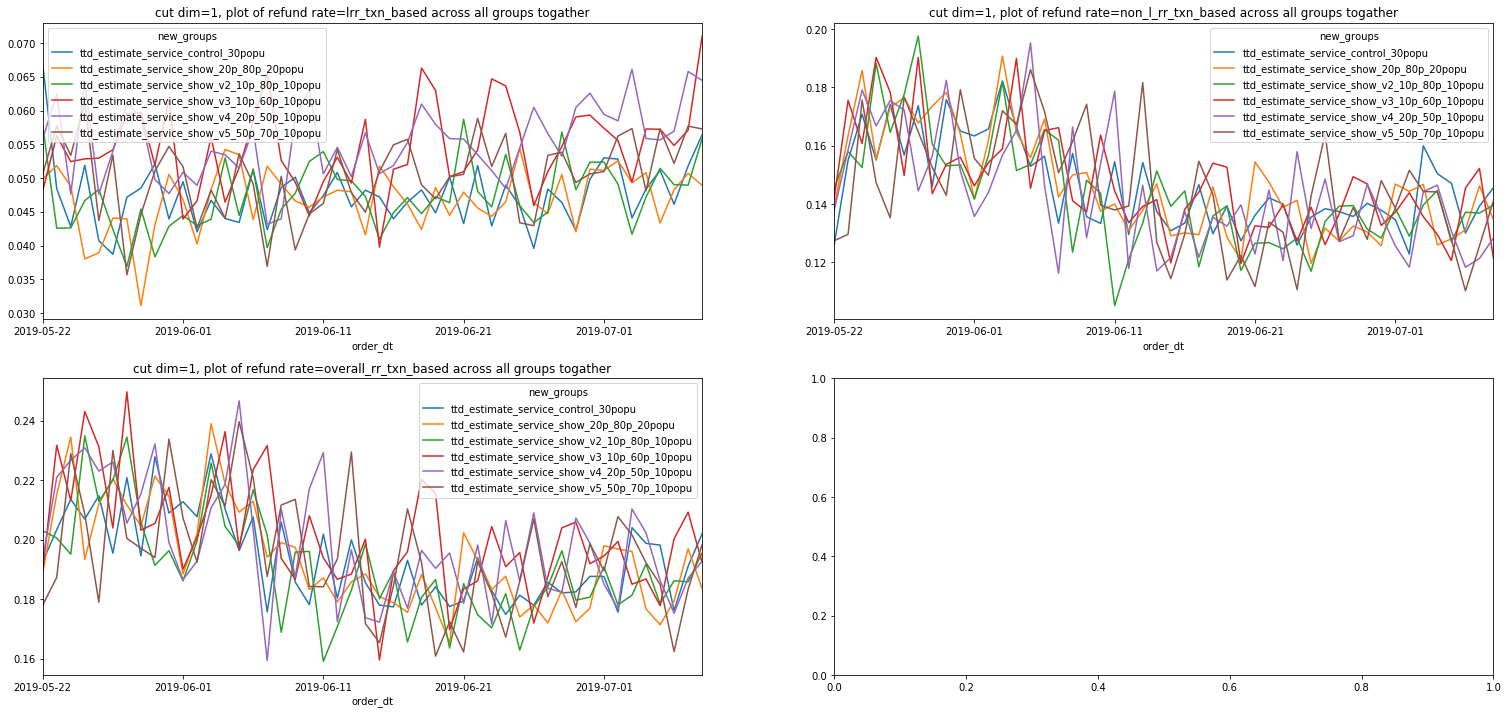

In [9]:
group = 'is_new_user'
df_lrr_all_cut_group = df_lrr_all_cut.groupby(['new_groups','order_dt',group],as_index=False)['orders','l_refund_orders','non_l_refund_orders','overall_refund_orders'].sum()
df_lrr_all_cut_group['lrr_txn_based']=df_lrr_all_cut_group.l_refund_orders / df_lrr_all_cut_group.orders
df_lrr_all_cut_group['non_l_rr_txn_based']=df_lrr_all_cut_group.non_l_refund_orders / df_lrr_all_cut_group.orders
df_lrr_all_cut_group['overall_rr_txn_based']=df_lrr_all_cut_group.overall_refund_orders / df_lrr_all_cut_group.orders


groups = list(set(df_lrr_all_cut[group]))

metrics = ['lrr_txn_based','non_l_rr_txn_based','overall_rr_txn_based']
countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU']

for g in groups:
    m = 2
    n = (len(metrics)+1) // m
    fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))
    
    for i in range(len(metrics)):
        x = i//m
        y = i%m
        df_lrr_all_cut_group.loc[df_lrr_all_cut_group[group]==g,['order_dt','new_groups',metrics[i]]].pivot_table(columns='new_groups', values=metrics[i], index='order_dt')\
        .plot(ax=axes[x][y], title='cut dim={}, plot of refund rate={} across all groups togather'.format(g,metrics[i]))

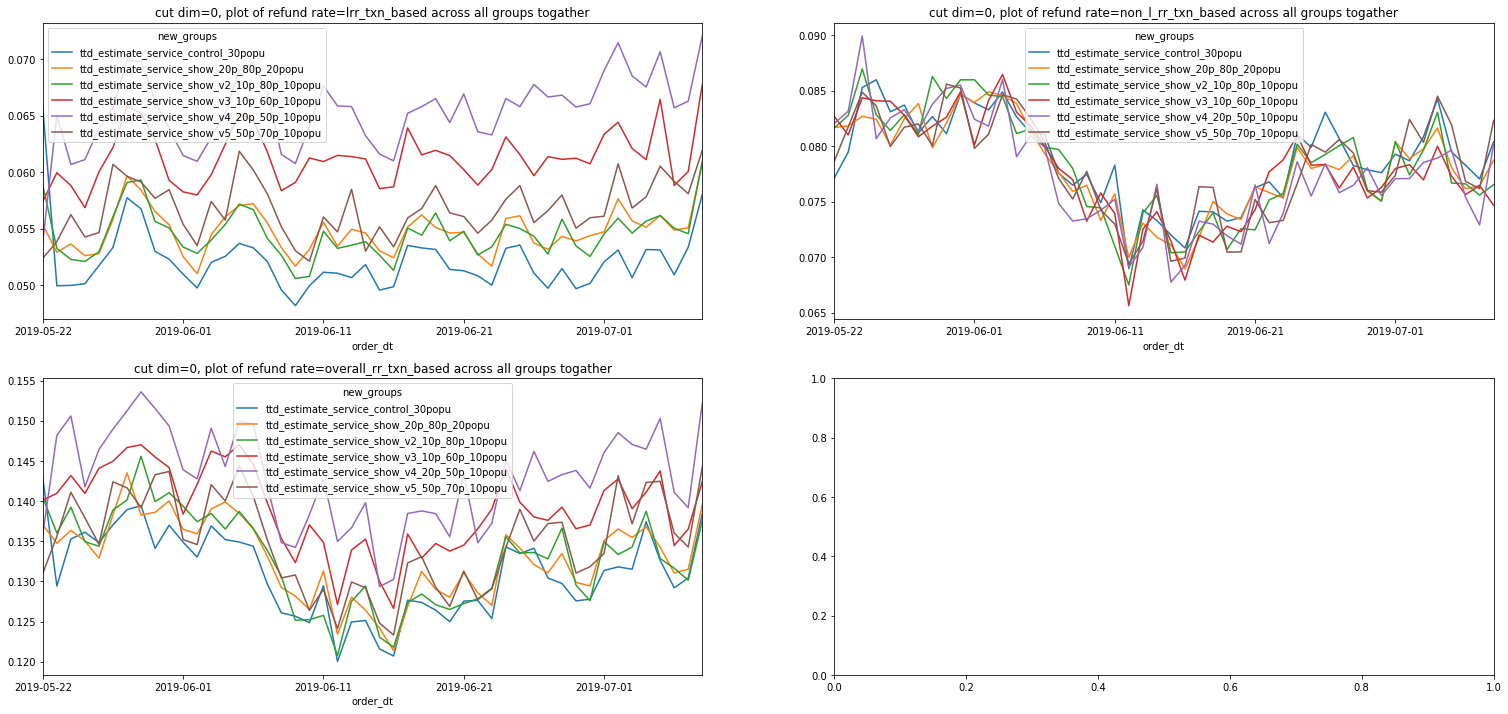

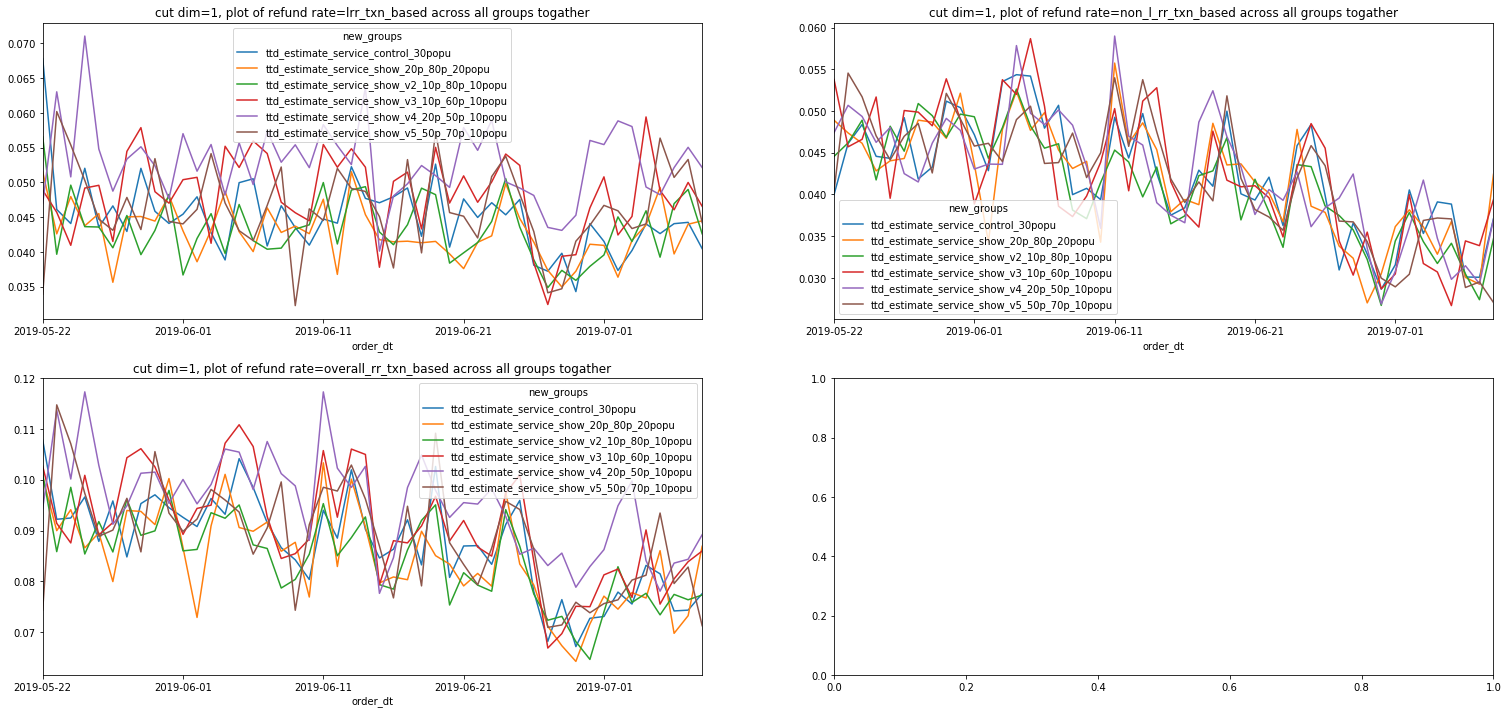

In [12]:
group = 'is_free_item'
df_lrr_all_cut_group = df_lrr_all_cut.groupby(['new_groups','order_dt',group],as_index=False)['orders','l_refund_orders','non_l_refund_orders','overall_refund_orders'].sum()
df_lrr_all_cut_group['lrr_txn_based']=df_lrr_all_cut_group.l_refund_orders / df_lrr_all_cut_group.orders
df_lrr_all_cut_group['non_l_rr_txn_based']=df_lrr_all_cut_group.non_l_refund_orders / df_lrr_all_cut_group.orders
df_lrr_all_cut_group['overall_rr_txn_based']=df_lrr_all_cut_group.overall_refund_orders / df_lrr_all_cut_group.orders


groups = list(set(df_lrr_all_cut[group]))

metrics = ['lrr_txn_based','non_l_rr_txn_based','overall_rr_txn_based']
countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU']

for g in groups:
    m = 2
    n = (len(metrics)+1) // m
    fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))
    
    for i in range(len(metrics)):
        x = i//m
        y = i%m
        df_lrr_all_cut_group.loc[df_lrr_all_cut_group[group]==g,['order_dt','new_groups',metrics[i]]].pivot_table(columns='new_groups', values=metrics[i], index='order_dt')\
        .plot(ax=axes[x][y], title='cut dim={}, plot of refund rate={} across all groups togather'.format(g,metrics[i]))

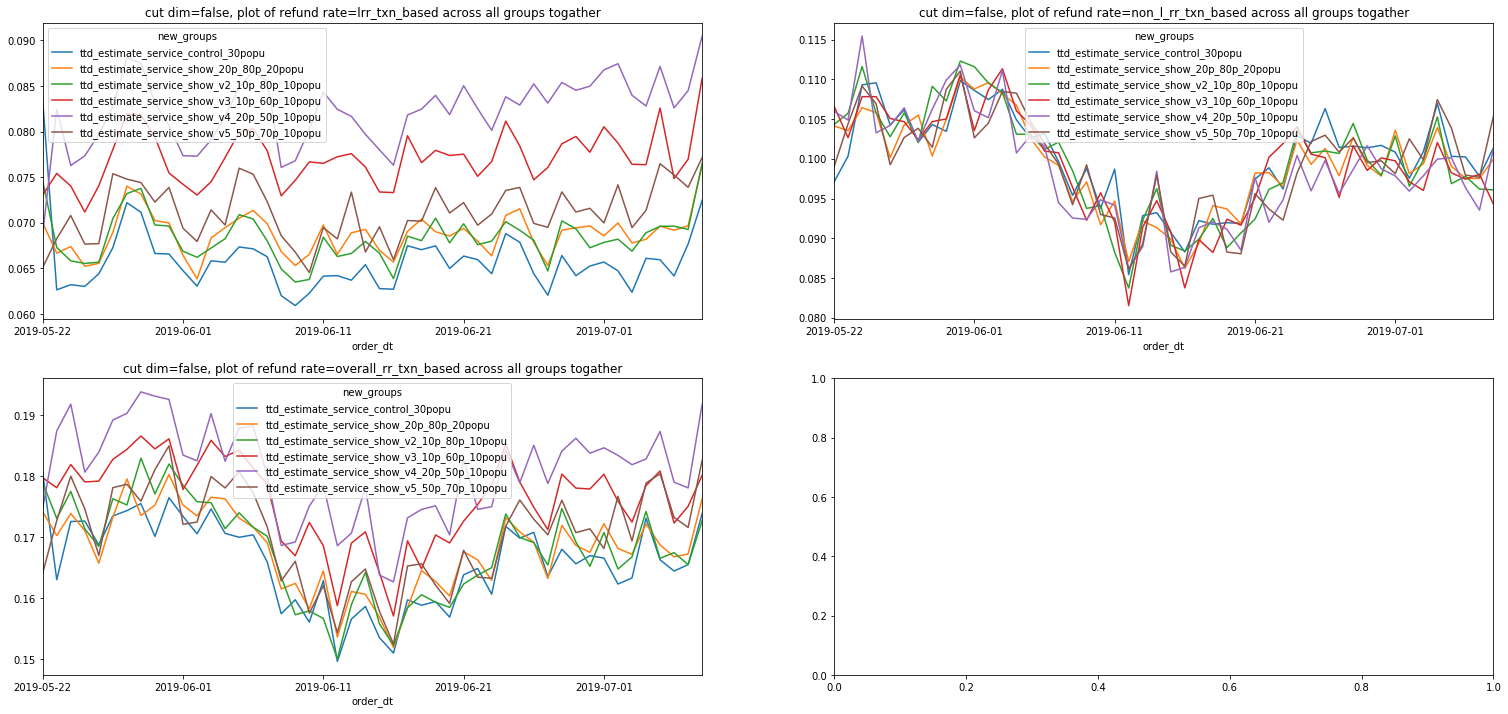

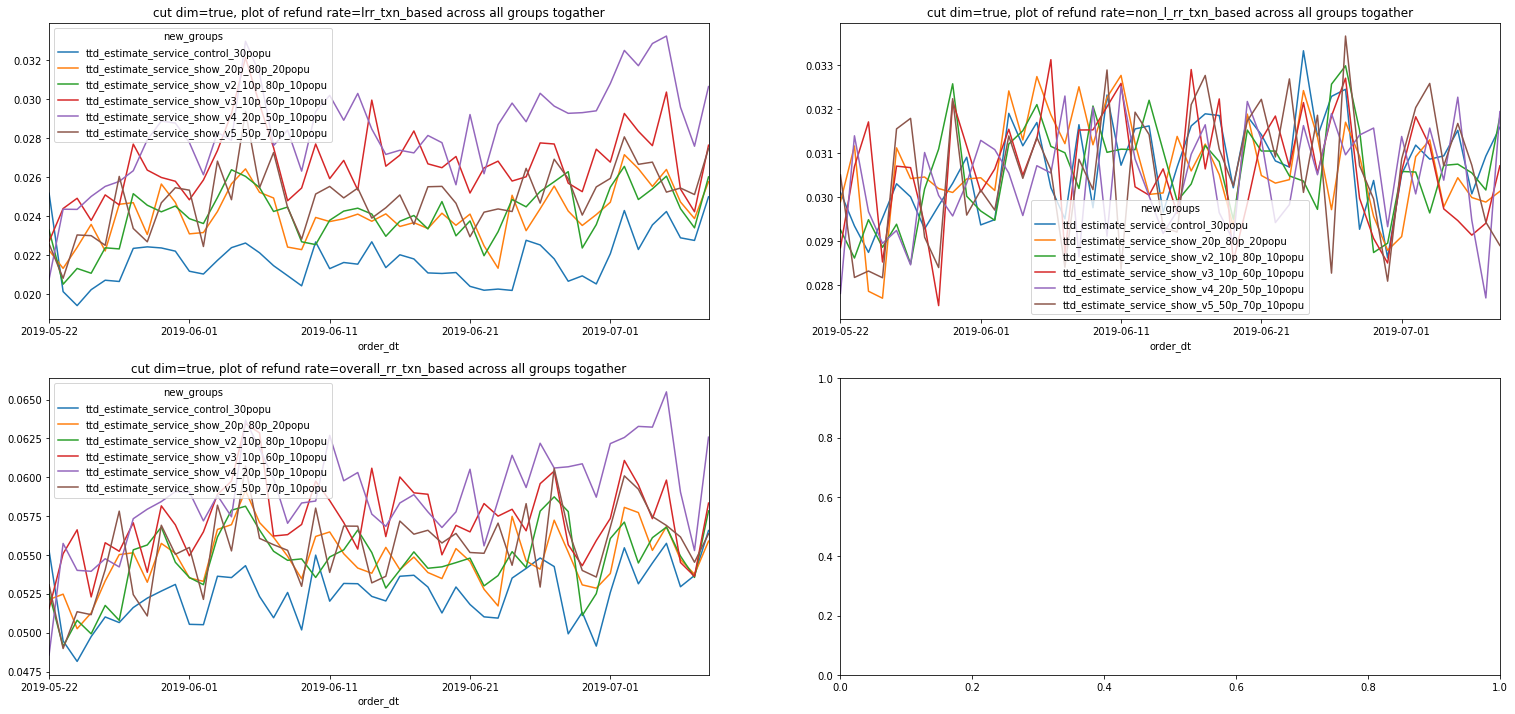

In [15]:
group = 'wishpost_registered'
df_lrr_all_cut_group = df_lrr_all_cut.groupby(['new_groups','order_dt',group],as_index=False)['orders','l_refund_orders','non_l_refund_orders','overall_refund_orders'].sum()
df_lrr_all_cut_group['lrr_txn_based']=df_lrr_all_cut_group.l_refund_orders / df_lrr_all_cut_group.orders
df_lrr_all_cut_group['non_l_rr_txn_based']=df_lrr_all_cut_group.non_l_refund_orders / df_lrr_all_cut_group.orders
df_lrr_all_cut_group['overall_rr_txn_based']=df_lrr_all_cut_group.overall_refund_orders / df_lrr_all_cut_group.orders


groups = list(set(df_lrr_all_cut[group]))

metrics = ['lrr_txn_based','non_l_rr_txn_based','overall_rr_txn_based']
countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU']

for g in groups:
    m = 2
    n = (len(metrics)+1) // m
    fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))
    
    for i in range(len(metrics)):
        x = i//m
        y = i%m
        df_lrr_all_cut_group.loc[df_lrr_all_cut_group[group]==g,['order_dt','new_groups',metrics[i]]].pivot_table(columns='new_groups', values=metrics[i], index='order_dt')\
        .plot(ax=axes[x][y], title='cut dim={}, plot of refund rate={} across all groups togather'.format(g,metrics[i]))

In [10]:
df_lrr_all_cut.head()

new_groups    order_dt shipping_country  \
0     ttd_estimate_service_show_20p_80p_20popu  2019-07-05               FR   
1          ttd_estimate_service_control_30popu  2019-06-14               IT   
2  ttd_estimate_service_show_v3_10p_60p_10popu  2019-06-19               IE   
3     ttd_estimate_service_show_20p_80p_20popu  2019-05-23               DK   
4          ttd_estimate_service_control_30popu  2019-06-10               BE   

   gender  education_level  is_new_user  is_free_item is_ltd_product  \
0       1              NaN            0             0           None   
1       2              NaN            0             0           None   
2       2              NaN            0             0           None   
3       1              NaN            0             0           None   
4       1              NaN            0             0           None   

  wishpost_registered  lrr_userid_based  ...  non_log_rr_stddev_userid_based  \
0                true            0.0047  ...                          0.1848   
1               false            0.0037  ...                          0.1954   
2               false            0.0000  ...                          0.1387   
3                true            0.0076  ...                          0.1231   
4               false            0.0038  ...                          0.1489   

   overall_rr_userid_based  overall_rr_stddev_userid_based  orders  \
0                   0.0401                          0.1963    3231   
1                   0.0434                          0.2038    2546   
2                   0.0195                          0.1387     425   
3                   0.0229                          0.1502     191   
4                   0.0264                          0.1605    1476   

   l_refund_orders  non_l_refund_orders  overall_refund_orders  lrr_txn_based  \
0               25                  129                    154       0.007738   
1               30                  180                    210       0.011783   
2                6                    5                     11       0.014118   
3                2                    3                      5       0.010471   
4               23                   29                     52       0.015583   

   non_l_rr_txn_based  overall_rr_txn_based  
0            0.039926              0.047663  
1            0.070699              0.082482  
2            0.011765              0.025882  
3            0.015707              0.026178  
4            0.019648              0.035230  

[5 rows x 22 columns]